## Autodiff

What is autodiff? In short it's a methodology that makes it much easier to compute gradients for functions, or to put it another way, it automatically tells you how fast a function is changing with respect to some input (fwd_diff) or output (bwd_diff)


Practially speaking, understanding how quicky a function changes is valuable for computing things like 

* Neural Rendering
  * Computing gradients for NeRFs (Neural Radiance Fields)
* Differentiable Rendering
  * Fitting 3d models to images
  * Optimzing material properties
  * Automatic lighting
* Physics simulation
  * Finite element method derivatives
  * Inverse kinematics & other optimization problems
* Procedural content generation
  * Optimized procedural noise.
* AI
  * Training neural networks large or small makes use of derivatives


This is by no means an exhaustive list. There are countless reasons to use autodiff in both graphics and compute settings.


# So why is this important?

* You only need to maintain 1 version of your functions​

* Slang generates the differentiable versions for you​

* Less chance of errors because slang maintains consistency for you



Let's look at an example. A great way to visually understand how we can use gradients to do useful stuff is with gradient descent. It's both simple and powerful.

In optimization, you define a loss function that measures how 'wrong' your function's output is. Gradient descent computes the gradients of this loss with respect to the function's parameters, then updates the parameters by taking a step in the direction opposite to the gradient (scaled by the learning rate) to reduce the loss.

We are first going to generate a set of x/y coordinates that loosely follow the quadratic function of a given set of coefficients, then we will get our gradient descent algorithm to learn a new set of coordinates that closely matches the first, purely by looking at the initial coordinates, not the coefficients that generated them. 

We will refer to our test data coefficients as our **target_coeffs** and our learned coefficients as our **initial_coefficients** because these start with an inital *guess* that will be optimized by our **autodiff** function.



In this example we are going to specify those launch bounds rather than let slangpy decide the best way to dispatch our function on the GPU. There are 2 main methods that we are going to call:

* **test_quadratic** 
  * This method will simply evaluate the quadratic function, updating the a *y output* that we can plot against an *x input*
* **main** 
  * This method is going to evaluate the loss metric and update the quadratic coefficients such that the inital guess of the curve fits the input data.

This way we get more control over how things will execute, and how our data is passed into and out of the shader.

Just as we did before, let's create the device and load the module.

In [1]:
import slangpy as spy 
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import random 


device = spy.create_device(include_paths=[os.getcwd()])


module = spy.Module.load_from_file(device, "slangpy_intro_autodiff.slang")

We are also going to create a simple host side method to generate a jittered version of our quadratic function. This will generate the points to which we will fit our learned quadratic coefficients.

In [2]:
def eval_2nd_degree_jitter(coeffs, x,j):
    
    a = coeffs[0] * (x**2)
    b = coeffs[1]  * x 
    c = coeffs[2]
    y = a+b+c 
    
    interval = [y-j, y+j]
    interval_min = interval[0]
    interval_max = interval[1] 
    
    jit_val = np.random.random() * interval_max 
    
    while interval_min > jit_val:
        jit_val = np.random.random() * interval_max 
        
    return jit_val


def eval_2nd_degree(coeffs,x):
    
    a = (coeffs[0]*(x**2))
    b = (coeffs[1]*x)
    c = (coeffs[2])
    y = a+b+c 
    return y 

Here we are setting up some host side arrays to initialze some data that we will send over to Slang:

* **point_count** - The number of points we will generate for for our test data.
* **min_val/max_val** - We are randomly generating *point_count* **x** coordinates between these two values
* **jitter_val** - How much we will *jitter* the **y** coordinate of our test data
* **target_coeffs_array** - A NumPy array to store the coefficients of our test data
* **initial_coeffs_array** - A NumPy array to store the **initial guess** of the coefficents that will be learned by gradient descent.
* **xy_input** - A NumPy array to store some random **x** amd **y** coordinates. 
  * These are not interleaved at this point, we update the latter half of the array with the jittered **y** coordinates.
  * We then reshape, transpose and reshape again.
* **loss_history** - We will track the loss of our function as it progresses through the optimization process and plot this at the end.
* **epochs** - The number of iterations that we will run for gradient descent
* **learning_rate** - The proportion of the gradients that we will use to update the parameters.

In [3]:
point_count = 128          #number of points to generate
min_val, max_val = -10,10  #min and max values for the randomly generated x coordinates
jitter_val = 25             #amount by which to jitter the y coordinate
epochs = 512               #the number of iterations that we will run for gradient descent
learning_rate = 0.0001     #the proportion of the gradients we will use to update the parameters.

#numpy array to store the coefficients for the test data
target_coeffs_array = np.array([2.0,-5.0,4.0], dtype=np.float32)

#numpy array to store the initial guess that will be optimized
#by gradient descent.
inital_coeffs_array = np.array([-1.0,3.0,-4.0], dtype=np.float32)

#numpy array to store our actual x and y coordinates of the test data.
xy_input = np.random.uniform(min_val, max_val, point_count * 2).astype(np.float32)

#generate the inital test data using our jittered quadratic function
for i in range(point_count):
    xy_input[i+point_count] = eval_2nd_degree_jitter(target_coeffs_array,xy_input[i],jitter_val)

#reshape our array to match the data type required by our slang kernel.
xy_input = xy_input.reshape((2,point_count)).transpose((1,0)).reshape((point_count*2))

#create an array to store the loss history
loss_history = np.ndarray((epochs,),dtype=np.float32)




To move the NumPy arrays we created in the previous step to the GPU so our shader(s) can use them we will create some buffers on the device specifying:

* **element_count** - how many elements we will need in this buffer
* **usage** - we need to tell **slangpy** how the buffer will be used so it can find the best heap for it for the given hardware
* **label** - Handy for debugging
* **struct_type** - Here we are using reflection to provide us with the size and alignment of the data type being used.
* **data** - The NumPy array that we will to populate our buffer with.


We are creating 4 buffers:

* **dp_buffer** - The DataPoints buffer - stores the *x* and *y* coordinates of the test data
* **qp_buffer** - The QuadraticParameters buffer - stores the target coefficients
  * Not actually needed for gradient descent
* **lh_buffer** - The loss history buffer where we store the loss for each iteration.
* **qpl_buffer** - The learned QuadraticParameters buffer. These parameters will be updated by gradient descent.

We also create 2 extra buffers to store the evaulated points of our initial guess and from a sample of the first few epochs of gradient descent.

In [4]:


dp_buffer_initial = device.create_buffer(
    element_count=point_count,
    usage=spy.BufferUsage.shader_resource | spy.BufferUsage.unordered_access,
    label="dataPoints",struct_size=8,
    data=xy_input
)

dp_buffer_5_epochs = device.create_buffer(
    element_count=point_count,
    usage=spy.BufferUsage.shader_resource | spy.BufferUsage.unordered_access,
    label="dataPoints",struct_size=8,
    data=xy_input
)

dp_buffer = device.create_buffer(
    element_count=point_count,
    usage=spy.BufferUsage.shader_resource | spy.BufferUsage.unordered_access,
    label="dataPoints",struct_size=8,
    data=xy_input
)

qp_buffer = device.create_buffer(
    element_count=1,
    usage=spy.BufferUsage.shader_resource | spy.BufferUsage.unordered_access,
    label="quadraticParams",
    struct_size=12,
    data= target_coeffs_array
)


lh_buffer = device.create_buffer(
    element_count=epochs,
    usage=spy.BufferUsage.shader_resource | spy.BufferUsage.unordered_access,
    label="loss_history", struct_size=4,
    data=loss_history
) 

qpl_buffer = device.create_buffer(
    element_count=1,
    usage=spy.BufferUsage.shader_resource | spy.BufferUsage.unordered_access,
    label="quadraticParams",
    struct_size=12,
    data= inital_coeffs_array
)


Let's plot our initial test data so we can see what we need to fit our curve to.

Text(0.5, 1.0, 'Cubic Plot')

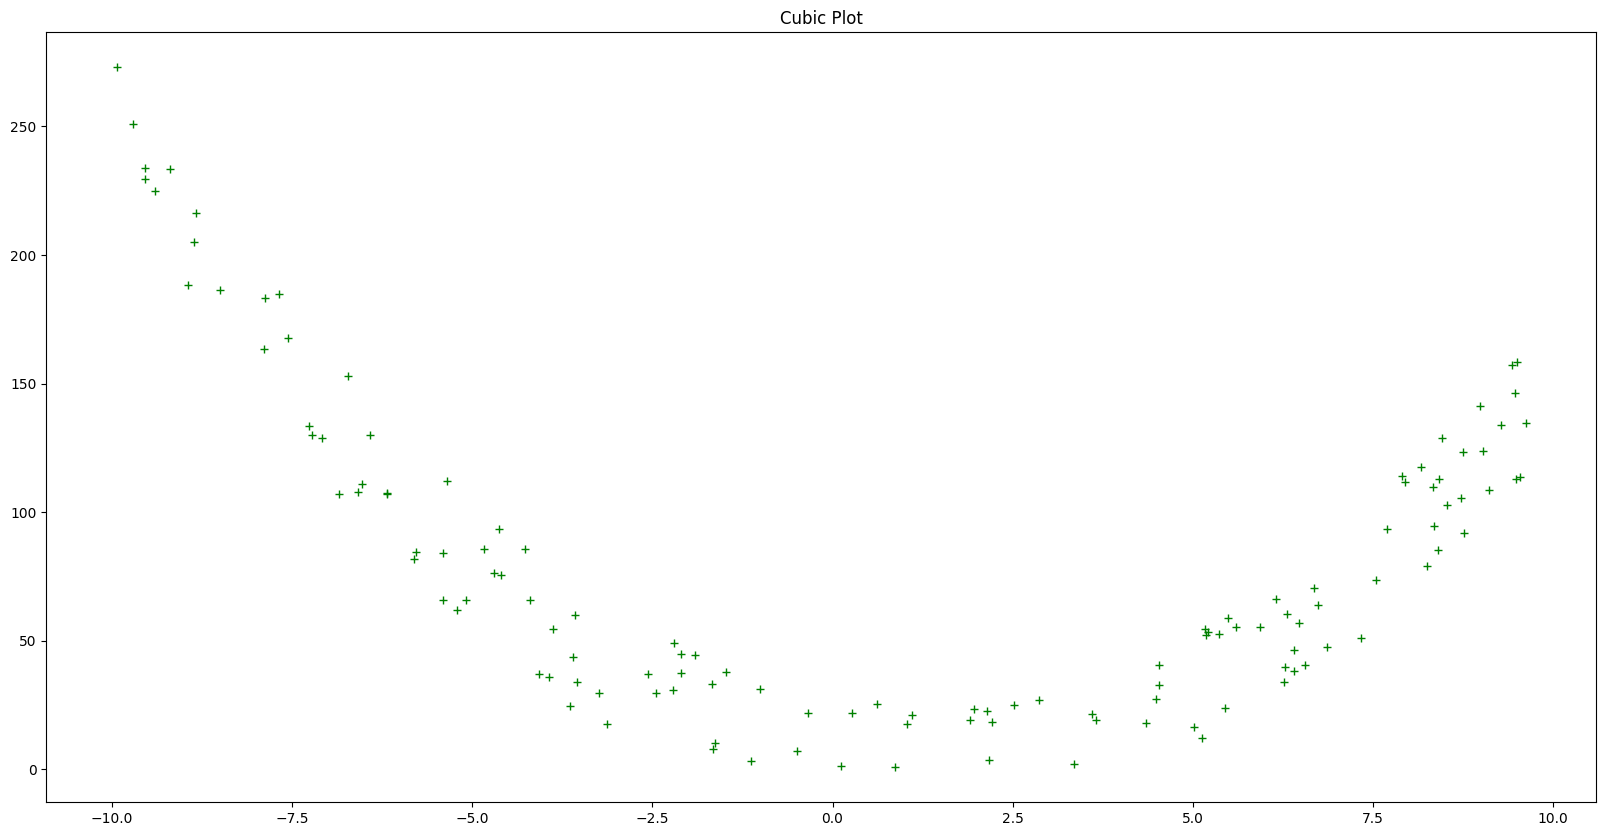

In [5]:
xy_input_plot = xy_input.reshape((point_count,2)).transpose((1,0))

plt.figure(figsize=(20,10))
plt.plot(xy_input_plot[0],xy_input_plot[1],'g+')
plt.title("Cubic Plot")

Now we will take the inital guess that we created earlier and see how well that fits the the data. 

Lets start by defining a few convienience methods in Python that will call our **Slang** kernels using **SlangPy**.

The first method will simply evaluate the quadratrc for some input. Notice that we use :

```python
module.test_quadratic.dispatch(...)
```

To dispatch the kernel in a way that allows us to specify the launch bounds. We are passing in the grid size in terms of threads rather than blocks.

This method also plots the results for us.

The second method will run gradient descent for the epoch count that we pass in. Note we are using a single thread to run gradient descent here. This is to simplify the gradient descent for the purposes of explanation. You would not want to run gradient descent this way in production. please refer to the 'BatchedGradientDescent' example to see how to dispatch this over a number of threads, making use of 'WaveActiveSum' to accumulate the loss. In this case we do actually update the weights on the CPU as, well, we only have 3 of them.

In [6]:
def compute_and_plot():
    module.test_quadratic.dispatch(
        (128,1,1),    
        dataPoints=dp_buffer_initial,
        params=qpl_buffer)
    
    dp_buffer_np = dp_buffer_initial.to_numpy().view(np.float32).reshape((point_count,2)).transpose((1,0))
                
    xy_input_plot = xy_input.reshape((point_count,2)).transpose((1,0))

    plt.figure(figsize=(20,10))
    plt.plot(xy_input_plot[0],xy_input_plot[1],'g+')
    plt.plot(dp_buffer_np[0],dp_buffer_np[1],'ro')
    plt.title("Cubic Plot")

def run_gradient_descent(num_epochs):
    
    for i in range(num_epochs):    
        module.main.dispatch((1,1,1), 
                         dataPoints=dp_buffer,
                         params=qpl_buffer,
                         lossHistory=lh_buffer,
                         epoch=i,
                         max_epochs=num_epochs,
                         point_count=point_count,
                         learning_rate=learning_rate)
            


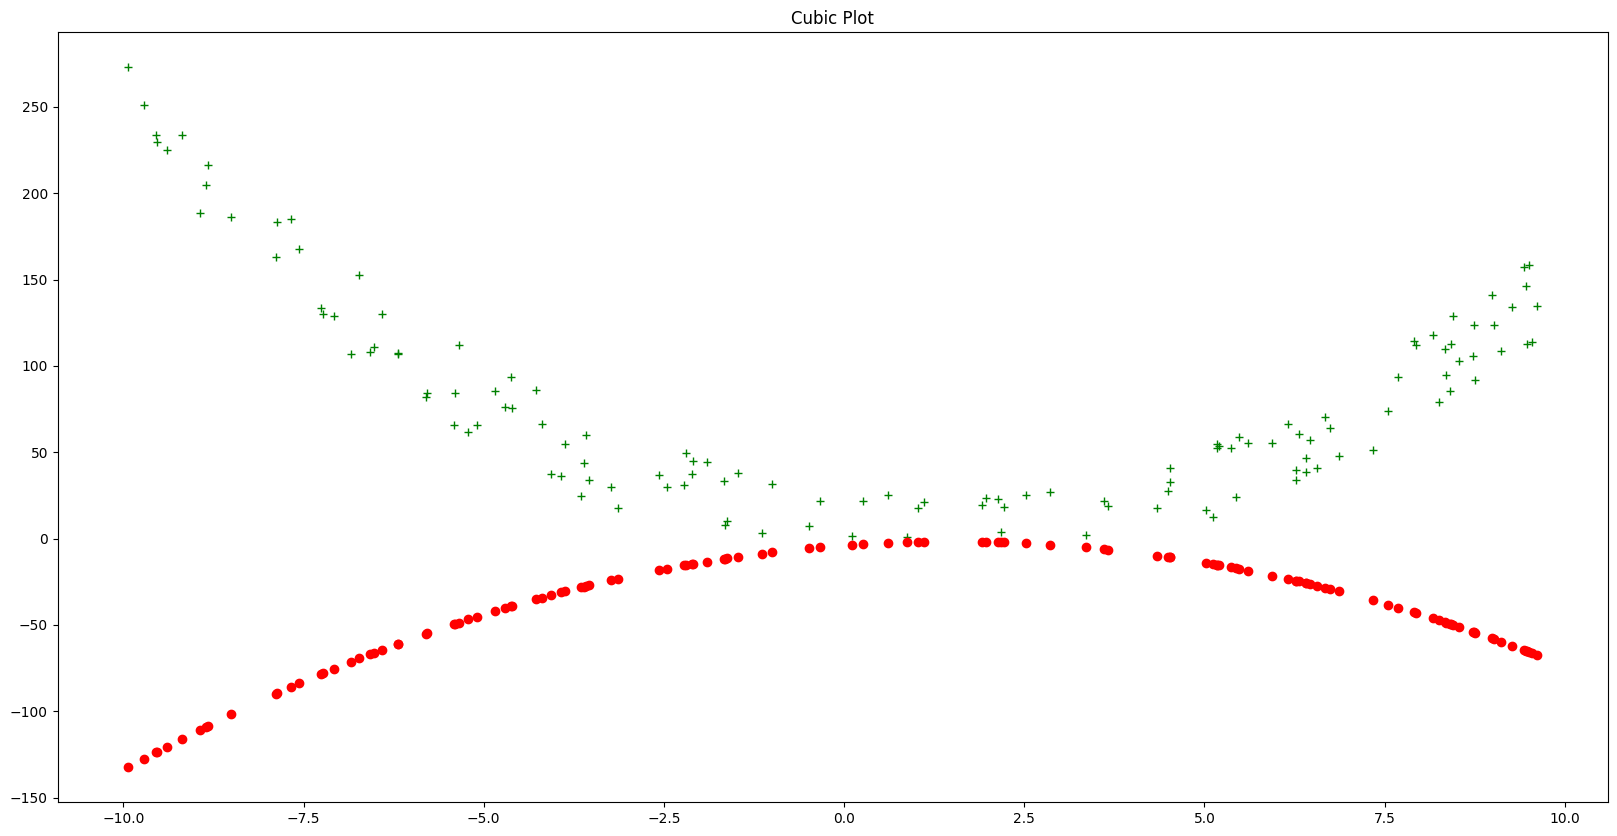

In [7]:

compute_and_plot()

So our initial guess was way off, but it was just a guess so what did we expect. Now we can run gradient descent to optimize this.


Let's run a few epochs and see if our coefficients have moved towards the target at all. We'll also plot the results to see how well we did.

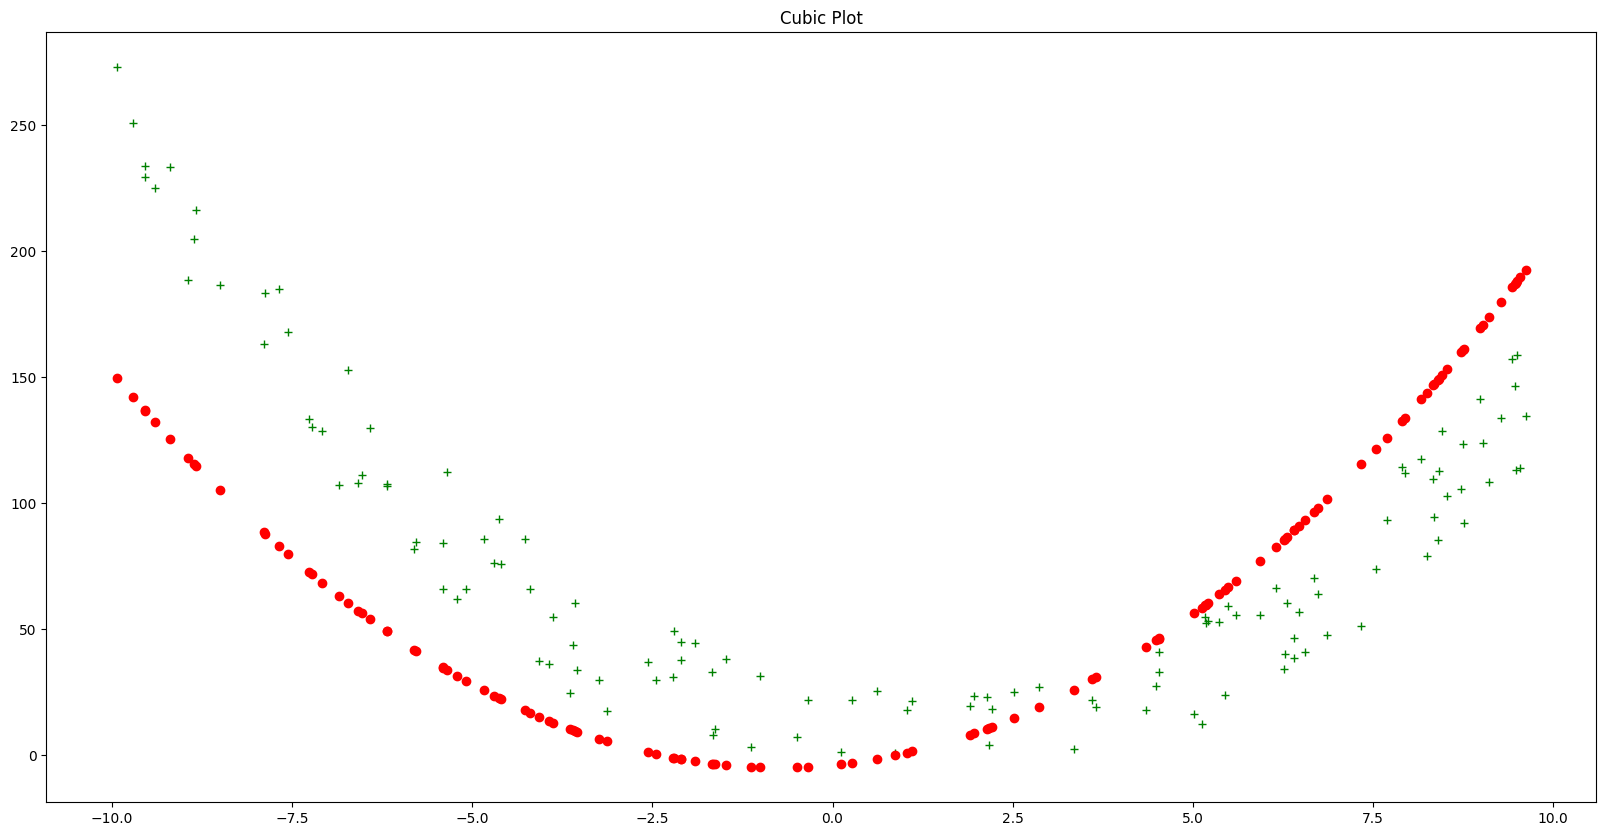

In [8]:
run_gradient_descent(5)
compute_and_plot()

It's certainly moved in the right direction, let's run a much larger amount of epochs. 512 in total.

Once again, let's plot the results.

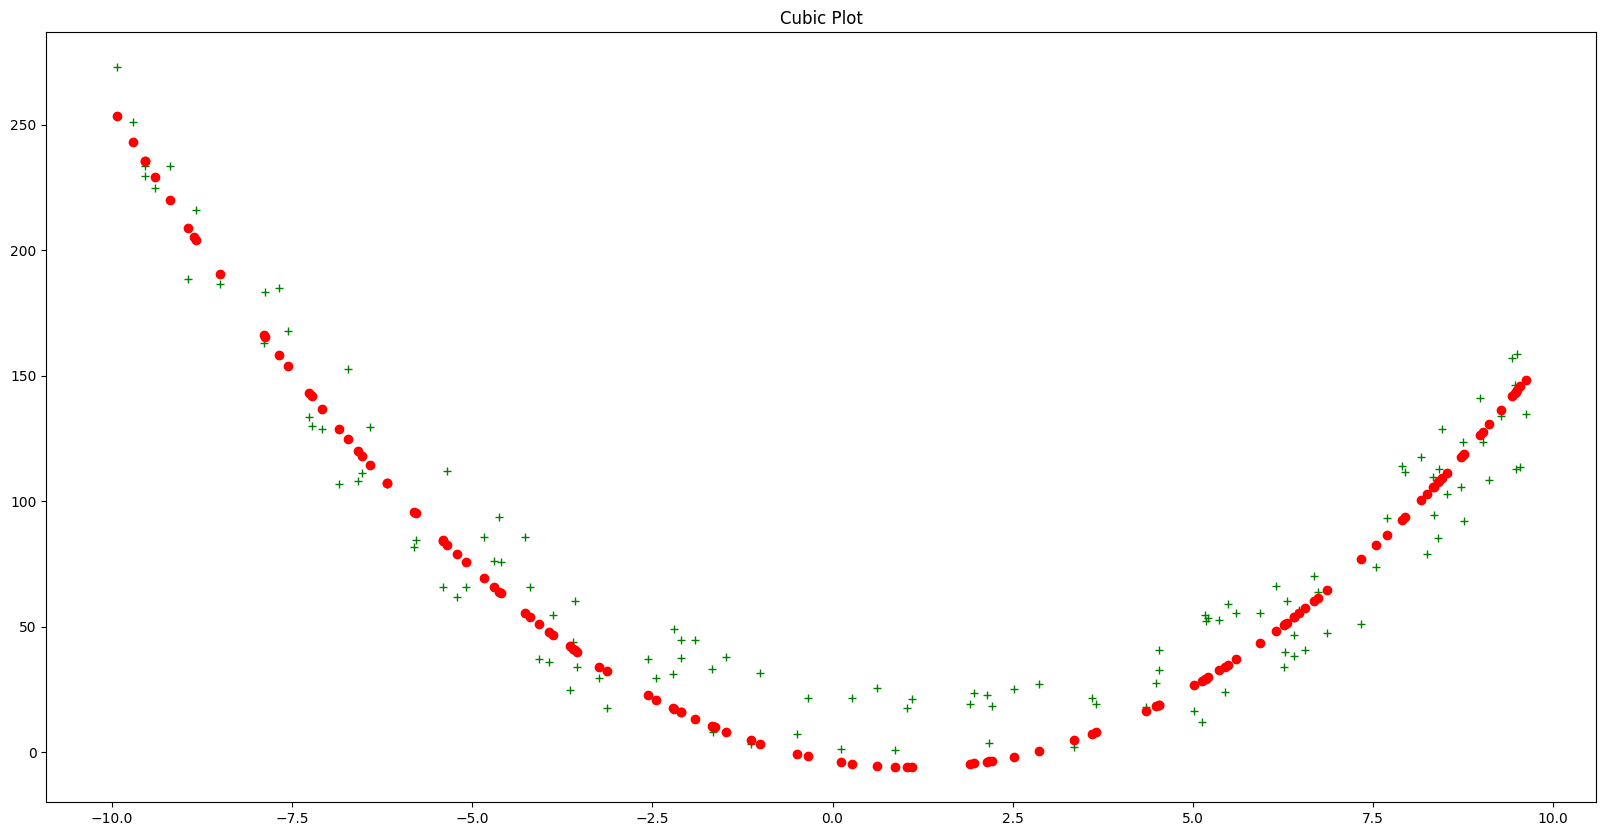

In [9]:
run_gradient_descent(epochs)
compute_and_plot()

We can also plot our loss over time. As we can see we converge nicely after about 400 epochs. 

Text(0.5, 1.0, 'Loss Plot')

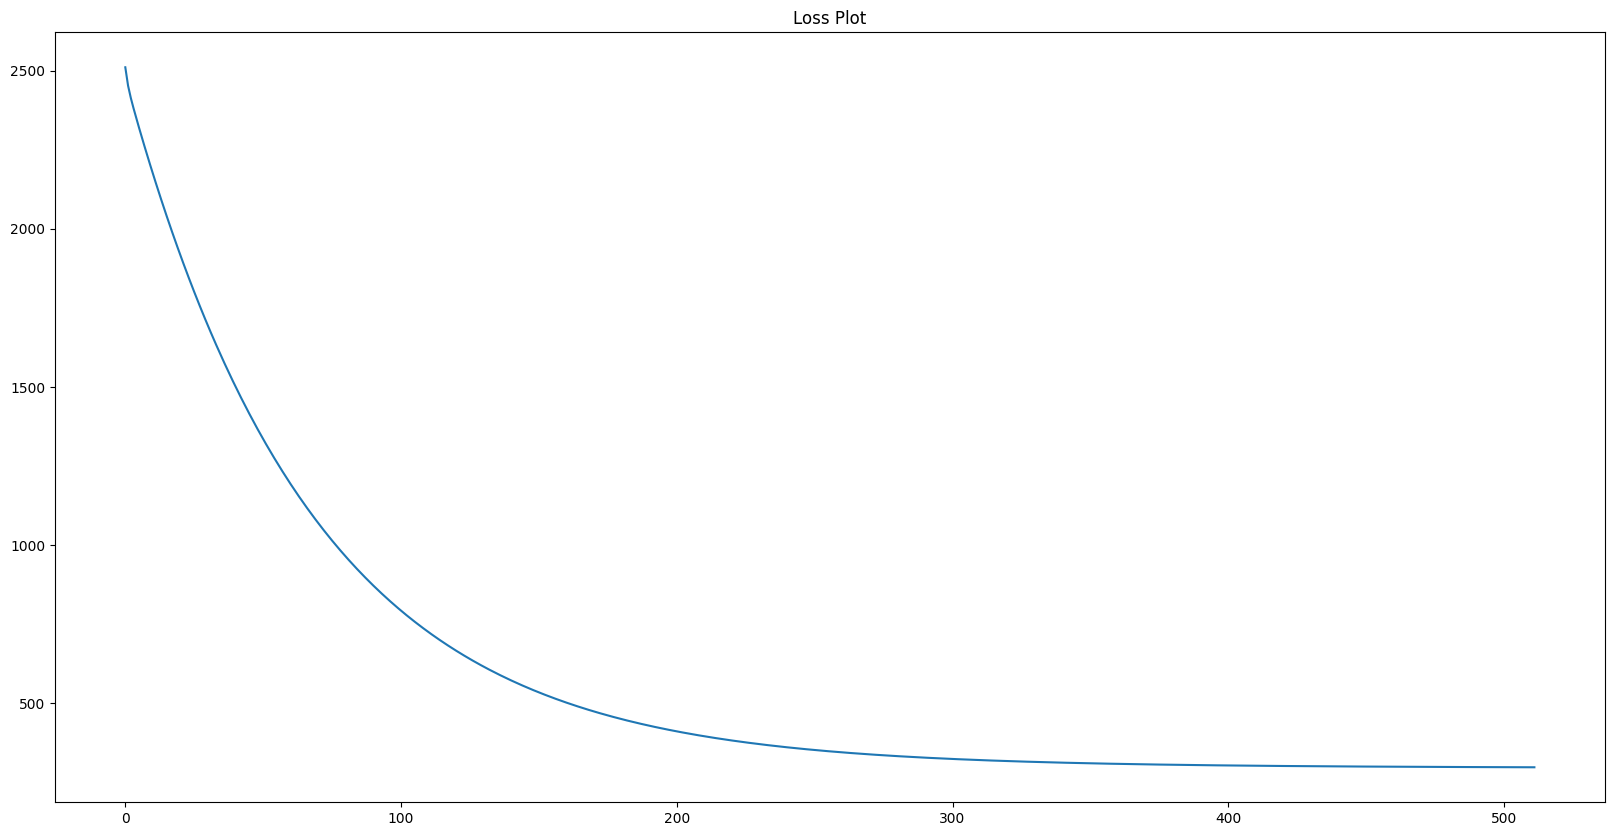

In [10]:
plt.figure(figsize=(20,10))
plt.plot(lh_buffer.to_numpy().view(np.float32))
plt.title("Loss Plot")